# Cognitive Modeling - Assignment 2
Yorick Juffer \
s1993623

## Libraries

In [24]:
import math
import random
from model import Model
from dmchunk import Chunk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions

In [25]:
t_0 = 0.011
a = 1.1
b = 0.15
add_noise = True

def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = t_0, a = a, b = b, add_noise = add_noise):  
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = t_0, a = a, b = b, add_noise = add_noise):
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

## Experiment

In [26]:
def experiment(n, t):

    fore_period = [0.4, 0.8, 1.2, 1.6]

    for i in range(n): 
        
        participant_model = Model()

        # train
        fore_period_rng = random.choice(fore_period)
        pulses = time_to_pulses(fore_period_rng)
        chunk = Chunk(name = "time" + str(i), slots = {"type": "time", "value": pulses})
        participant_model.add_encounter(chunk)
        participant_model.time += 0.1

        pastFP = fore_period_rng

        # trials
        for j in range(t):

            reaction_time = 0.410
            fore_period_rng = random.choice(fore_period)

            # pre stimulus
            blend_pattern = Chunk(name = "fore_period", slots = {"type": "time"})
            memory = participant_model.retrieve_blended_trace(blend_pattern, "value")

            difference = fore_period_rng - pulses_to_time(memory[0]  * 0.33)
            participant_model.time += memory[1] + 0.05
            
            if(difference >= 0.05):
                reaction_time =  reaction_time - 0.05
            elif(difference <= 0):
                reaction_time =  reaction_time
            else: 
                reaction_time =  reaction_time - difference

            participant = i
            currentFP = fore_period_rng

            if(i == 0):
                results = np.array([[participant, reaction_time, currentFP, pastFP]])
            else:
                results = np.append(results, [[participant, reaction_time, currentFP, pastFP]], axis=0)

            pastFP = fore_period_rng
            
            # post stimulus
            pulses = time_to_pulses(fore_period_rng)
            chunk = Chunk(name = "time" + str(i) + str(j), slots = {"type": "time", "value": pulses})
            participant_model.add_encounter(chunk)
            participant_model.time += 0.1
            
            print("Participant: {}/{}".format(i + 1, n), end="\r")

    return results

# runs the experiment and generates data 896
data = experiment(50, 1000)
dataFrame = pd.DataFrame(data)
dataFrame.columns = ["pp", "RT", "FP", "FPp"]


## Data

           RT                              
FPp       0.4       0.8       1.2       1.6
FP                                         
0.4  0.364385  0.368727  0.372320  0.376118
0.8  0.361672  0.365184  0.367469  0.366781
1.2  0.361929  0.362326  0.364505  0.366067
1.6  0.361550  0.362303  0.362769  0.362837


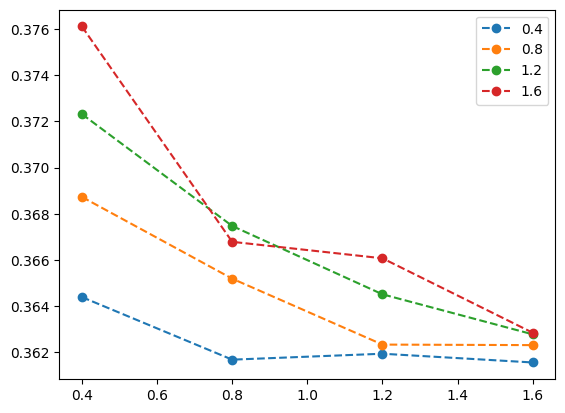

In [27]:
df = dataFrame
df.drop('pp', inplace=True, axis=1)
grouped_df = df.groupby(["FP", "FPp"]).mean().unstack()
print(grouped_df)
plt.plot(grouped_df, linestyle='--', marker='o', label = ["0.4", "0.8", "1.2", "1.6"])
plt.legend(loc='upper right')
plt.show()
